In [38]:
import os
import torch
from transformers import pipeline, AutoModelForSemanticSegmentation, AutoImageProcessor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Suppress Hugging Face cache warnings (Optional)
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [39]:
# Check PyTorch installation
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")  # Should be False

PyTorch version: 2.4.1+cpu
CUDA available: False


In [40]:
# Task 1: Object Segmentation
def segment_object(image_path, class_name, output_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Load the model and processor
    model_dir = './segformer-b0-finetuned-ade-512-512'
    
    if not os.path.exists(model_dir):
        raise FileNotFoundError(f"Model directory '{model_dir}' does not exist.")
    
    model = AutoModelForSemanticSegmentation.from_pretrained(model_dir, torch_dtype=torch.float32)
    processor = AutoImageProcessor.from_pretrained(model_dir)
    
    segmenter = pipeline('image-segmentation', model=model, feature_extractor=processor, device=-1)

    # Predict the segmentation
    segments = segmenter(image)

    # Debug: Print the segments
    print("Segments:", segments)

    # Check if the class name exists in the segmentation results
    mask = None
    for seg in segments:
        print(f"Label: {seg['label']}, Score: {seg['score']}")  # Debug output
        if seg['label'].lower() == class_name.lower():
            mask = seg['mask']
            break
    
    if mask is None:
        raise ValueError(f"Class '{class_name}' not found in the image.")

    # Convert mask to a binary image
    mask_img = Image.fromarray(np.uint8(mask) * 255)
    mask_img = mask_img.convert("L")  # Convert to grayscale

    # Visualize the original image and the mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_img, cmap='gray')
    plt.title('Segmentation Mask for ' + class_name)
    plt.axis('off')
    
    plt.show()

    # Create a red color mask
    red_mask = Image.new("RGBA", image.size, (255, 0, 0, 0))
    red_mask.paste((255, 0, 0, 128), mask=mask_img)
    
    # Composite image
    image_with_mask = Image.alpha_composite(image.convert("RGBA"), red_mask)

    # Save the result
    image_with_mask.save(output_path)
    
    print(f"Segmented image saved to {output_path}")
    return output_path, segments, mask_img  # Return the mask for further processing


In [41]:
# Task 2: Pose Editing
def edit_pose(image_path, mask_img, azimuth, output_path):
    # Load the segmented image
    image = Image.open(image_path).convert("RGBA")
    
    # Convert the mask to a NumPy array
    mask_array = np.array(mask_img)

    # Create a blank RGBA image for the output
    edited_image = Image.new("RGBA", image.size)

    # Convert the original image to an array for manipulation
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2BGRA)

    # Find the contours of the masked area
    contours, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours are found
    if len(contours) > 0:
        # Assume we take the first contour found (there should only be one for the chair)
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Create a mask for the ROI
        roi_mask = np.zeros_like(mask_array)
        cv2.drawContours(roi_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

        # Extract the ROI using the mask
        roi = cv_image[y:y + h, x:x + w][roi_mask[y:y + h, x:x + w] > 0]

        # Calculate rotation matrix for pose editing
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, azimuth, 1.0)
        
        # Rotate the ROI
        rotated_roi = cv2.warpAffine(roi, M, (w, h), flags=cv2.INTER_LINEAR)

        # Create a new image to hold the edited result
        edited_image = Image.fromarray(cv2.cvtColor(cv_image, cv2.COLOR_BGRA2RGBA))

        # Paste the rotated ROI back into the original image
        edited_image.paste(Image.fromarray(rotated_roi), (x, y), mask=Image.fromarray(roi_mask[y:y + h, x:x + w]))

    # Save the edited image
    edited_image.save(output_path)
    print(f"Pose-edited image saved to {output_path}")



Segments: [{'score': None, 'label': 'wall', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x2408493A750>}, {'score': None, 'label': 'floor', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x24083D46B10>}, {'score': None, 'label': 'ceiling', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x24081843010>}, {'score': None, 'label': 'windowpane', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x24084A0F290>}, {'score': None, 'label': 'table', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x240849A7410>}, {'score': None, 'label': 'chair', 'mask': <PIL.Image.Image image mode=L size=320x320 at 0x24084A4B990>}]
Label: wall, Score: None
Label: floor, Score: None
Label: ceiling, Score: None
Label: windowpane, Score: None
Label: table, Score: None
Label: chair, Score: None


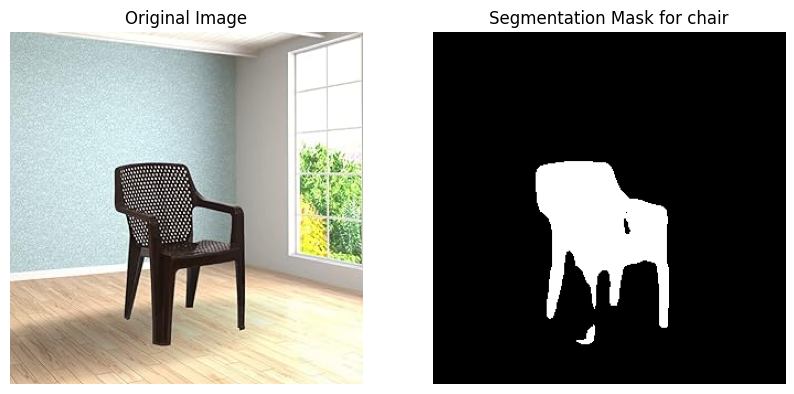

Segmented image saved to ./segmented_output.png
Pose-edited image saved to ./pose_edited_output.png


In [42]:
# Example usage of both tasks
segmented_image_path, segments, chair_mask = segment_object(
    image_path='./chair.jpg',
    class_name='chair',
    output_path='./segmented_output.png'
)

# Perform pose editing if the mask is found
edit_pose(
    image_path=segmented_image_path,
    mask_img=chair_mask,  # Use the correct mask
    azimuth=180,           # Change this value for different rotations
    output_path='./pose_edited_output.png'
)